In [1]:
import torch.multiprocessing as mp
mp.set_sharing_strategy("file_system")

In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path("..").resolve()))

In [3]:
!pwd

/home/neoph/dev/Train/Jupyter/KaryoTest/notebooks


In [4]:
import torch
from torch.utils.data import DataLoader
from datasets.cfg import num_classes, max_size
from models.models import build_model
from datasets.loader import DataModule, DataConfig
from datasets.base import collate_bb
from train.eval import Evaluator
from train.unsupervised_metrics import UnlabeledSanity
import mlflow.pytorch
device = torch.device("cuda")

model_B = build_model("maskrcnn_r50_fpn", num_classes).to(device)
model_B.load_state_dict(torch.load("../weights/maskrcnn_B_ep40.pth", map_location="cuda"))

model_uri = "file:///media/sdb1/mlflow/753485487056022103/2e19afb3d8e34c7fa8b50505a7dd259e/artifacts/model"
model_AB_Att = mlflow.pytorch.load_model(model_uri)

model_uri = "file:///media/sdb1/mlflow/811912879539272586/f5a5b06105074b00add2d669786d3dff/artifacts/model"
model_AB_Att2 = mlflow.pytorch.load_model(model_uri)

/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/tmp/ipykernel_3517749/4032923325.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value 

In [5]:
data = DataModule(DataConfig())
loader_B_test = data.make_loader_b_test()
loader_A_test  = data.make_loader_a_test()
loader_D_test  = data.make_loader_d_test()

loader_D_test_number = data.make_loader_d_test_number()
loader_D_test_struct = data.make_loader_d_test_structural()
e = Evaluator(device)


Examples: B-test, B model


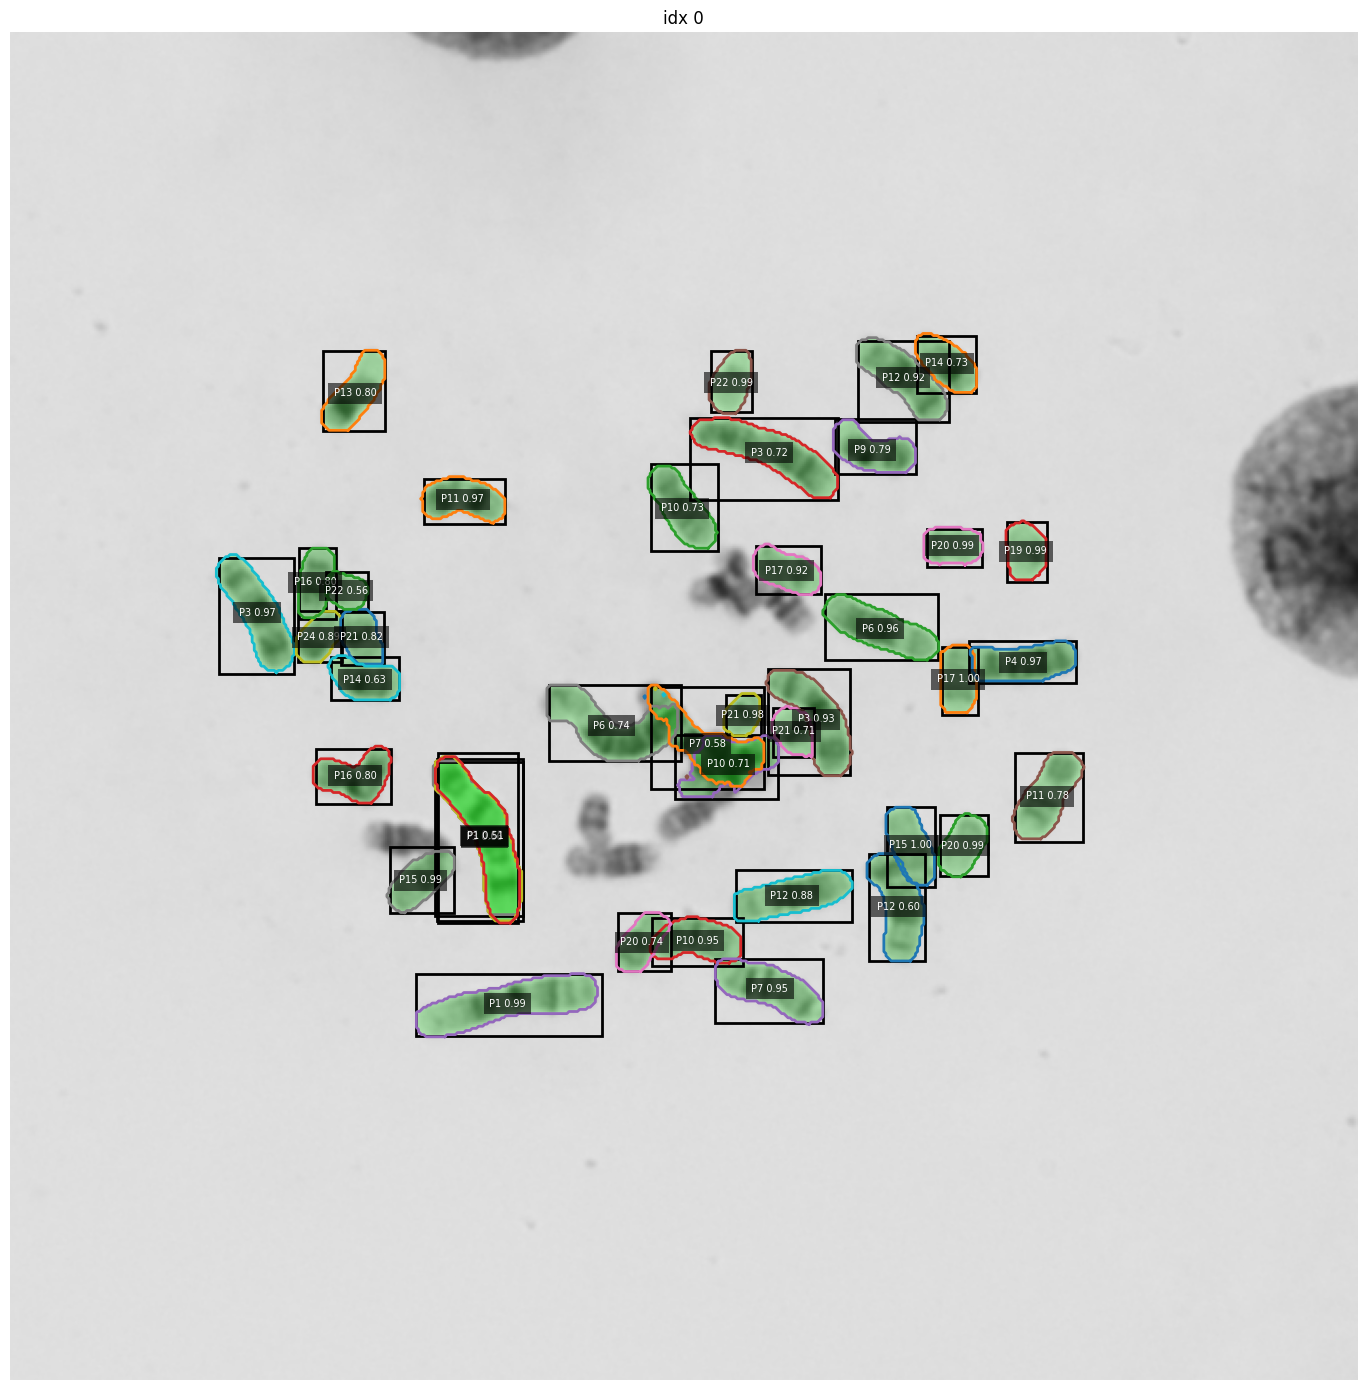


Examples: B-test, Att model


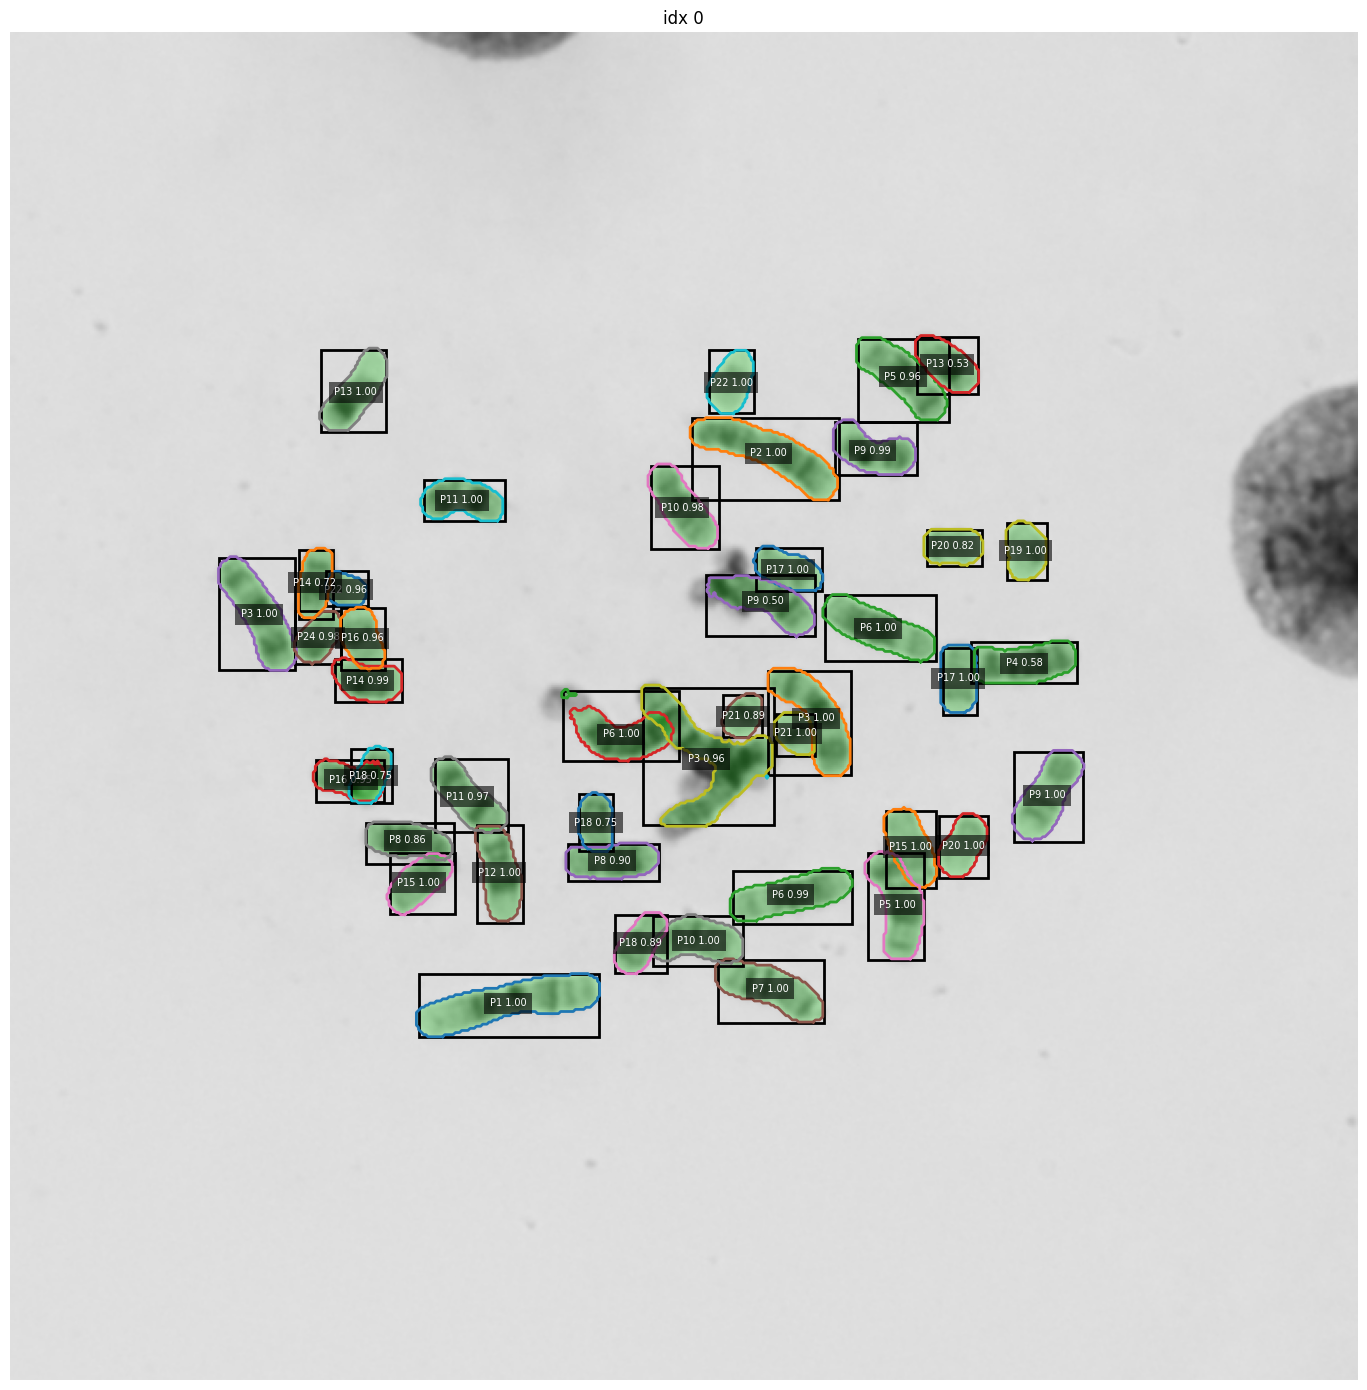

In [7]:
e.show_examples(data.ds_b_test, model_B,  n=1, score_thresh=0.5, title="B-test, B model")
e.show_examples(data.ds_b_test, model_AB_Att2, n=1, score_thresh=0.5, title="B-test, Att model")


Examples: D-test, B model


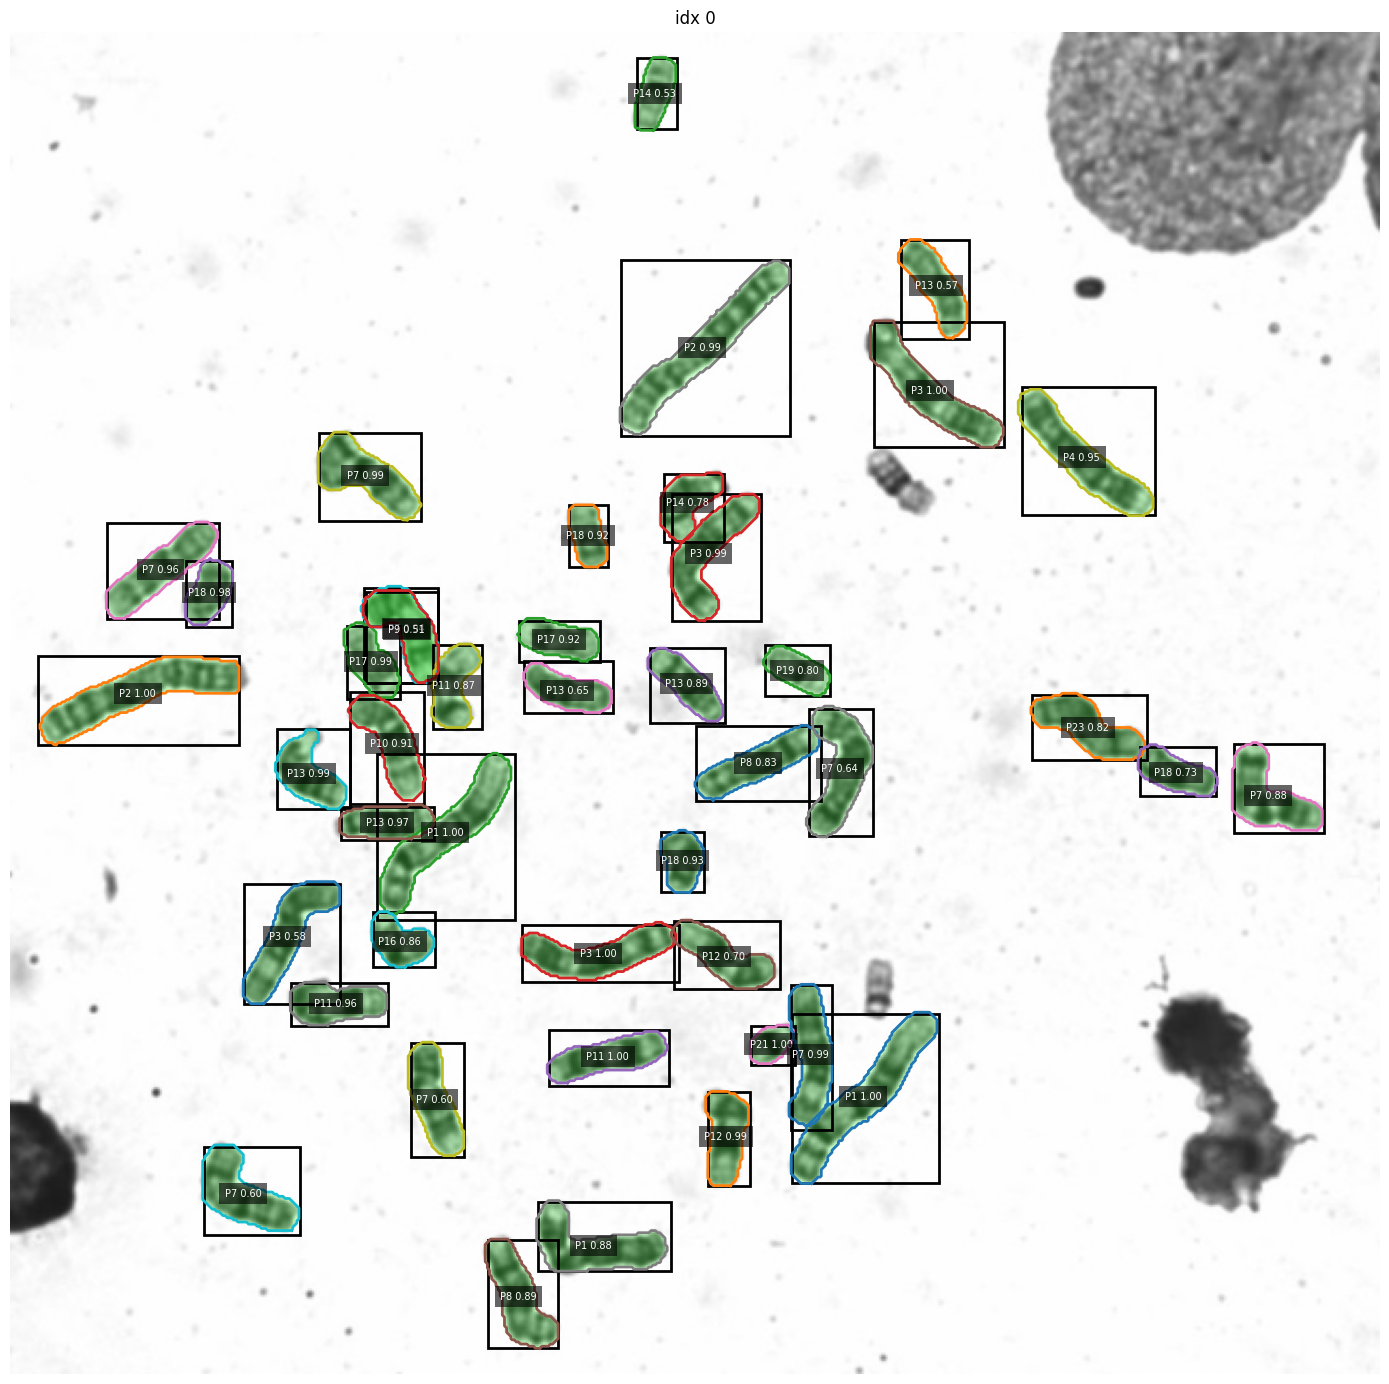


Examples: D-test, Att model


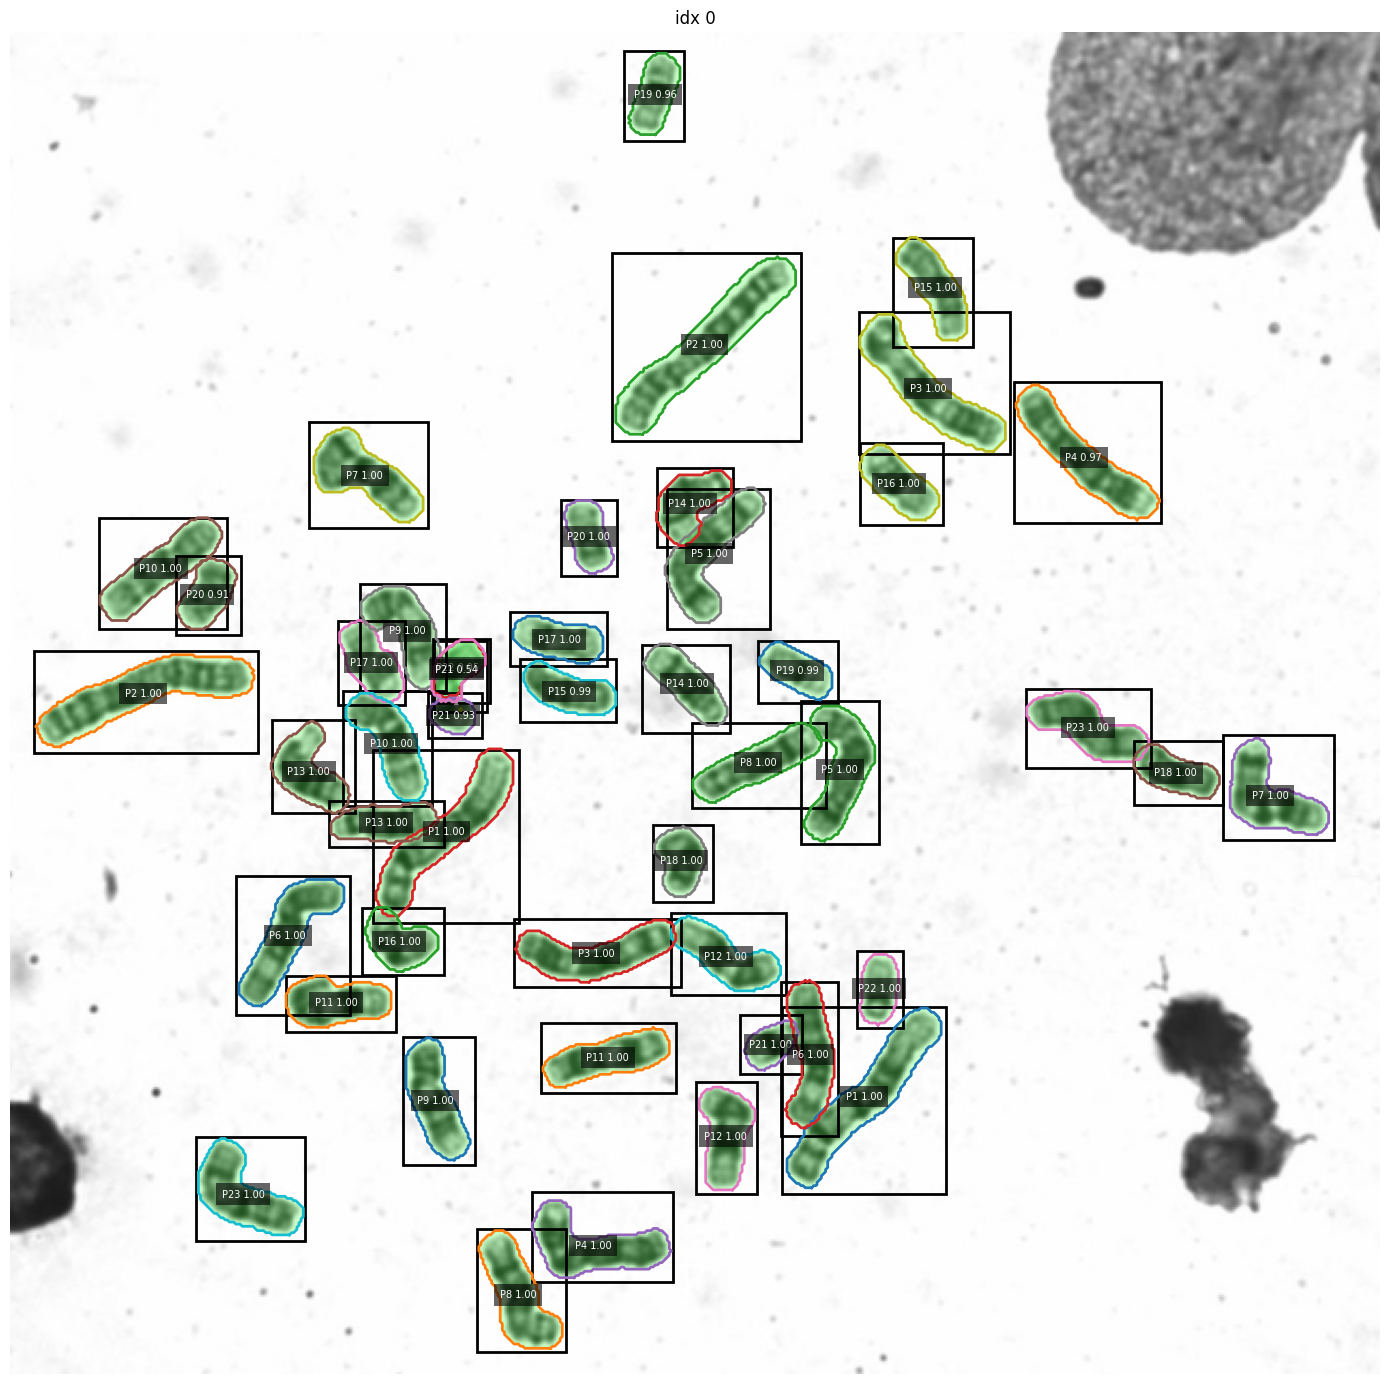

In [8]:
e.show_examples(data.ds_d_test, model_B,  n=1, score_thresh=0.5, title="D-test, B model")
e.show_examples(data.ds_d_test, model_AB_Att2, n=1, score_thresh=0.5, title="D-test, Att model")

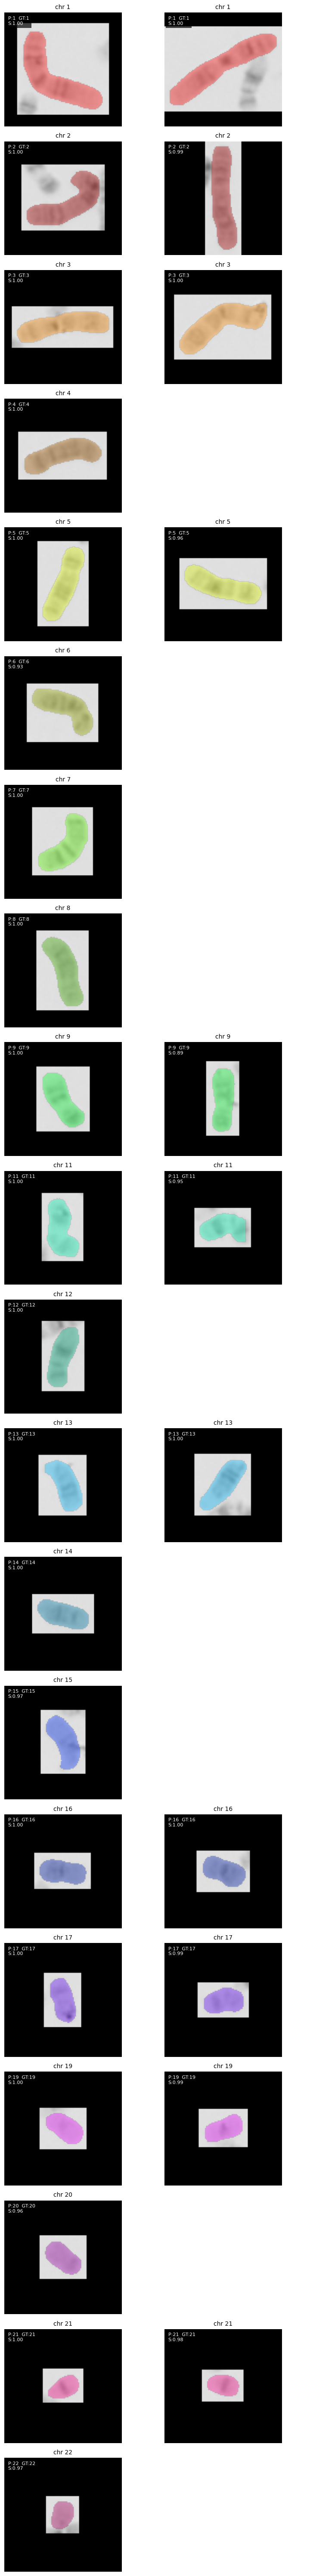

In [14]:

from train.karyo_plotting4 import plot_karyogram_from_output

def plot_karyogram_from_dataset(dataset, model, idx=0, score_thresh=0.5, pad=5):
    model.eval()
    img_t, target = dataset[idx]
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    plot_karyogram_from_output(img_t.cpu(), out, target, idx=idx, score_thresh=score_thresh, pad=pad)

plot_karyogram_from_dataset(data.ds_b_test, model_AB_Att2, idx= 1)


Examples: D-test, Att model


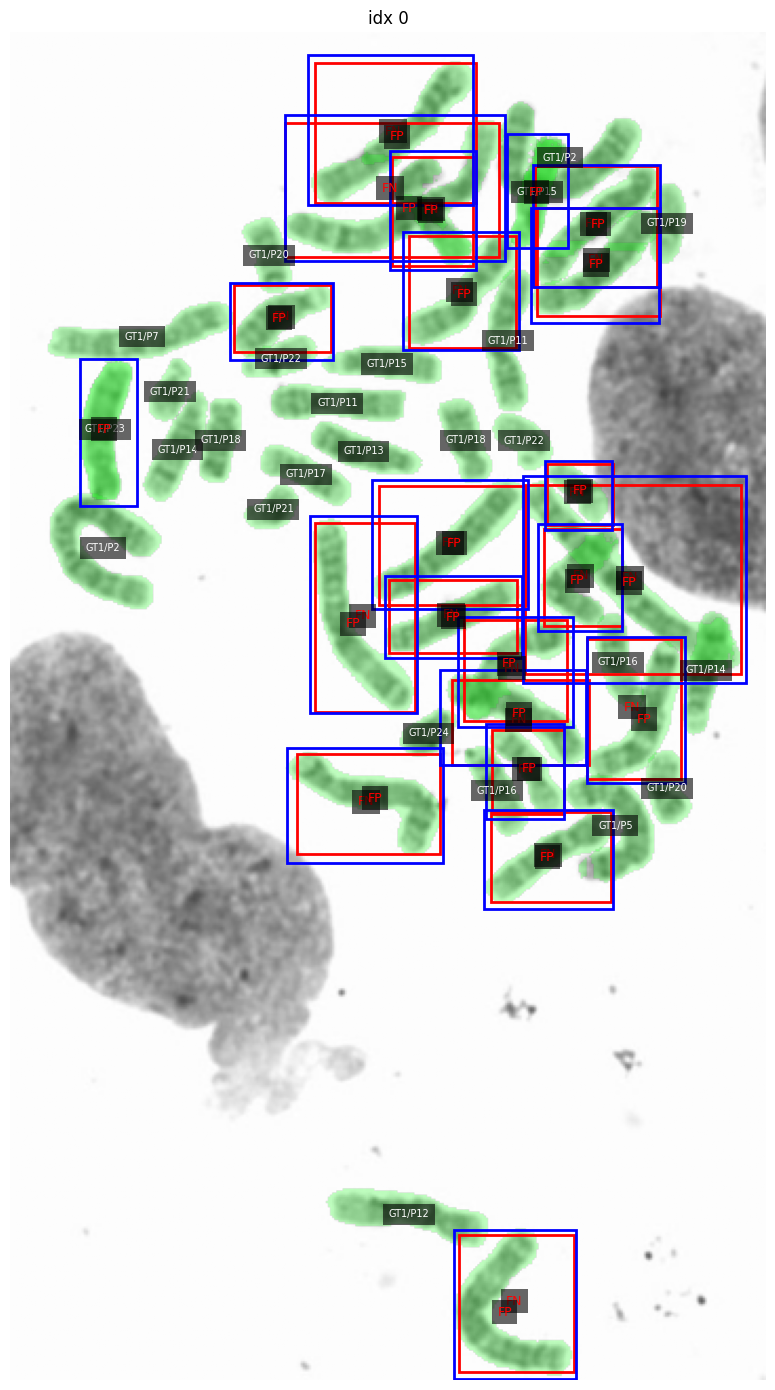


Examples: D-test, Att model


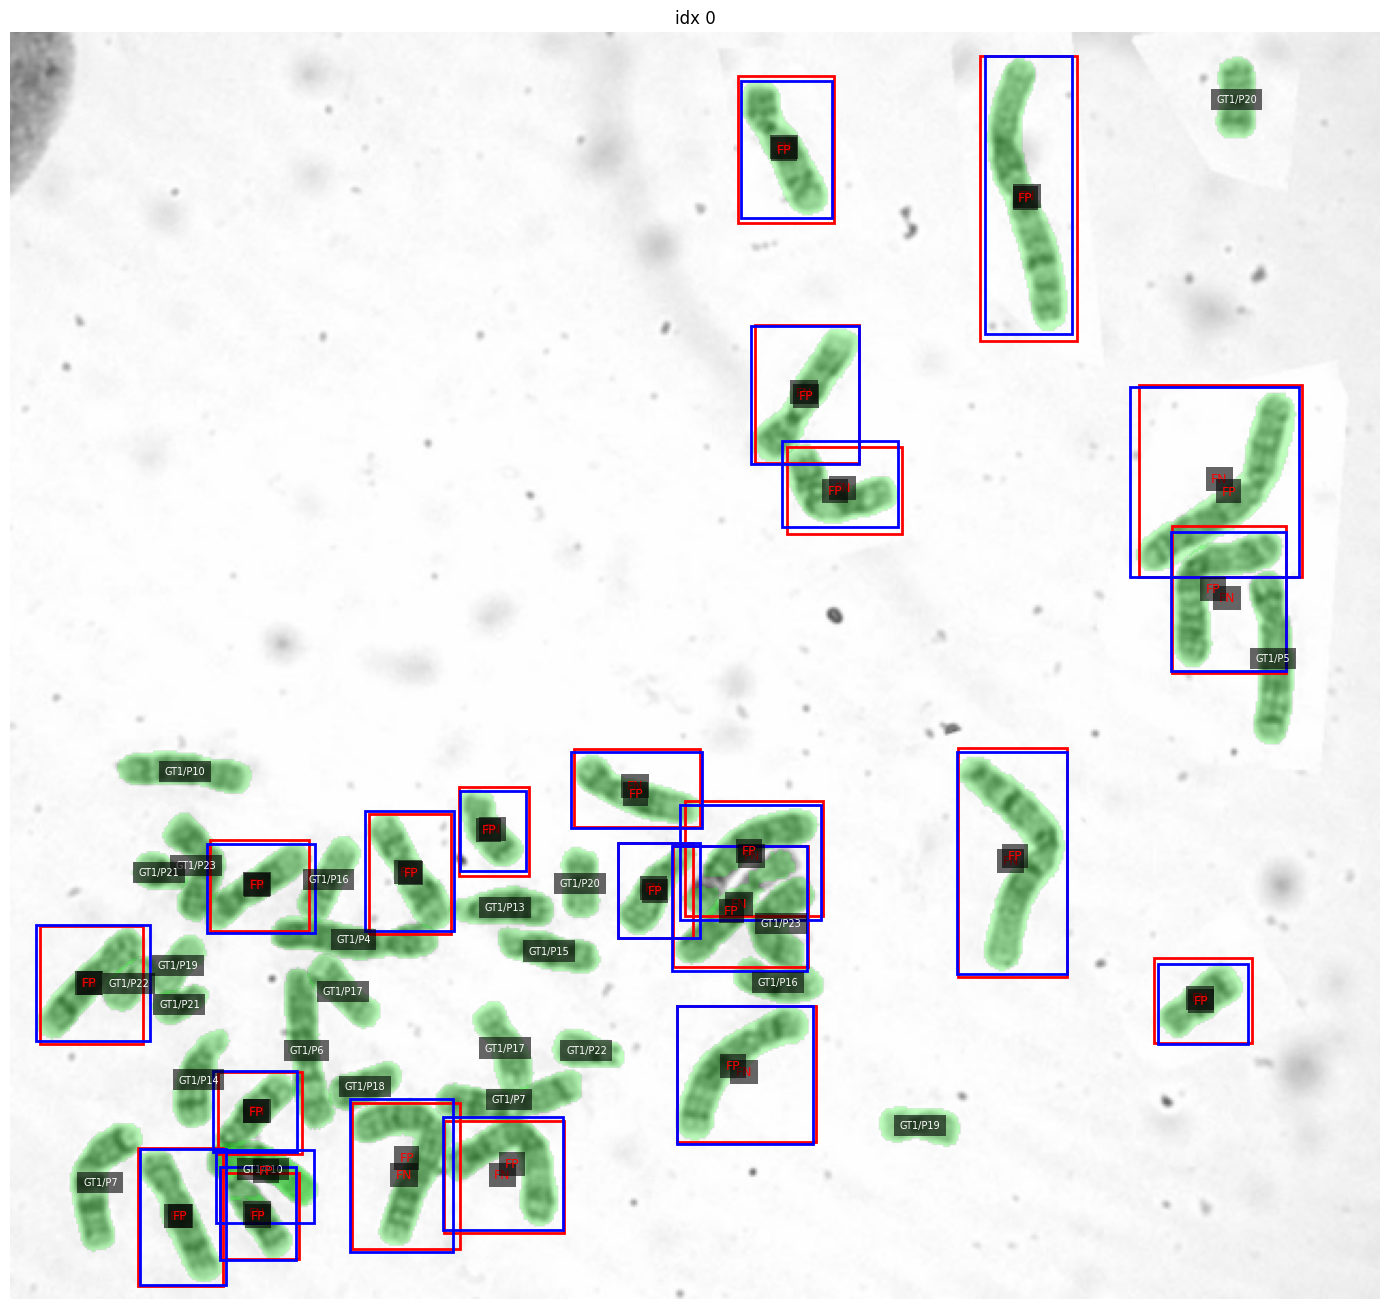

In [9]:
e.show_examples(data.ds_d_test_structural, model_AB_Att2,  n=1, score_thresh=0.5, title="D-test, Att model")
e.show_examples(data.ds_d_test_number, model_AB_Att2, n=1, score_thresh=0.5, title="D-test, Att model")

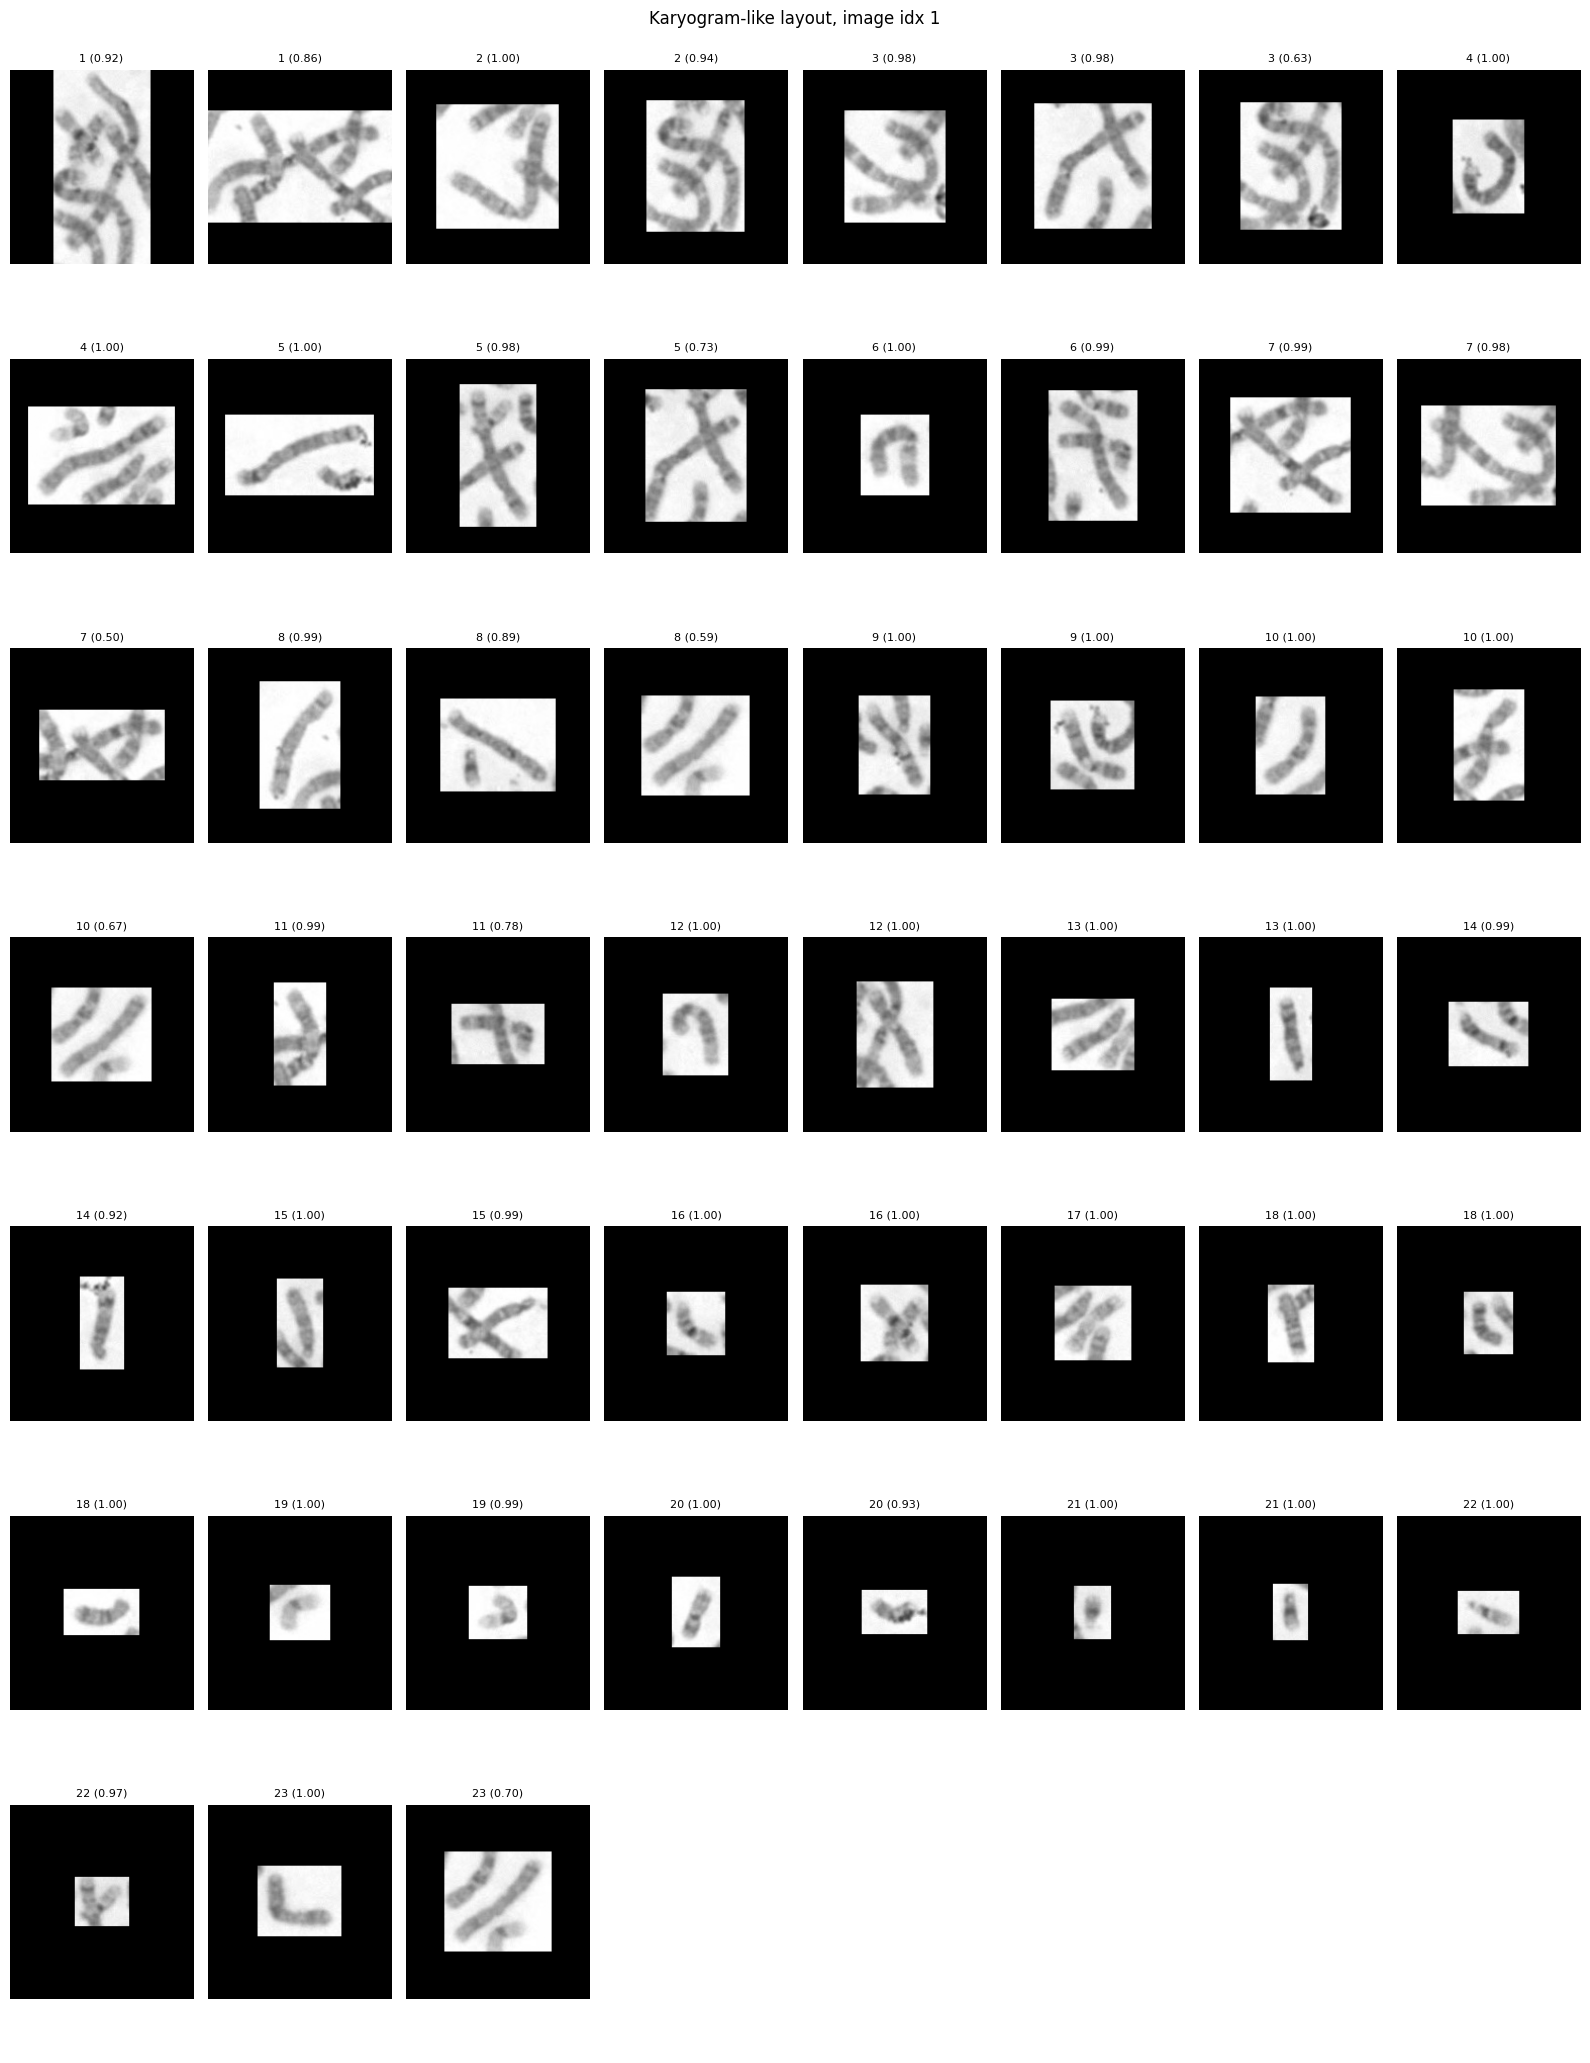

In [10]:
from train.karyo_plotting2 import plot_karyogram_from_output

def plot_karyogram_from_dataset(dataset, model, idx=0, score_thresh=0.5,pad=5,cols=8):
    model.eval()
    img_t, _ = dataset[idx]
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    plot_karyogram_from_output(img_t.cpu(), out, idx, score_thresh, pad, cols)

plot_karyogram_from_dataset(data.ds_d_test_number, model_AB_Att2, idx= 1)

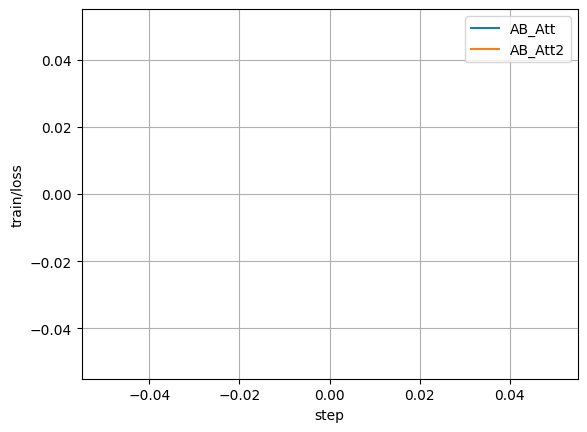

In [3]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mlflow.tracking import MlflowClient

def tracking_root_from_model_uri(model_uri: str) -> str:
    p = Path(model_uri.replace("file://", ""))
    # .../<tracking_root>/<exp_id>/<run_id>/artifacts/model
    return "file://" + str(p.parents[3])

def run_id_from_model_uri(model_uri: str) -> str:
    p = Path(model_uri.replace("file://", ""))
    return p.parts[-3]

def metric_history_df(client: MlflowClient, run_id: str, key: str) -> pd.DataFrame:
    h = client.get_metric_history(run_id, key)
    return pd.DataFrame({"step": [m.step for m in h], "value": [m.value for m in h]}).sort_values("step")

def plot_metric(model_uris: list[str], labels: list[str], metric_key: str):
    tracking_uri = tracking_root_from_model_uri(model_uris[0])
    mlflow.set_tracking_uri(tracking_uri)
    client = MlflowClient(tracking_uri=tracking_uri)

    plt.figure()
    for uri, label in zip(model_uris, labels):
        run_id = run_id_from_model_uri(uri)
        df = metric_history_df(client, run_id, metric_key)
        plt.plot(df["step"], df["value"], label=label)
    plt.xlabel("step")
    plt.ylabel(metric_key)
    plt.legend()
    plt.grid(True)
    plt.show()

model_uris = [
    "file:///media/sdb1/mlflow/753485487056022103/2e19afb3d8e34c7fa8b50505a7dd259e/artifacts/model",
    "file:///media/sdb1/mlflow/811912879539272586/f5a5b06105074b00add2d669786d3dff/artifacts/model",
]
labels = ["AB_Att", "AB_Att2"]

plot_metric(model_uris, labels, "train/loss")

